# Heat Transfer in Ice

This notebook is meant to give you a better feeling for the time scales of diffusion in ice. We use a numerical model of the heat equation
$$ \frac{\partial T}{\partial t} = \alpha \nabla^2 T - u\cdot \nabla T + \frac{\phi}{\rho C_p} $$
to test some simple scenarios. It is not important that you understand the details of the model, or even that you have a background in coding with python. Most of the work has been done so that you can adjust inputs to the model and test the result.

### 1) Surface Perturbation

In [13]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

spy  = 60.*60.*24.*365.24          # sec yr-1
alpha = 1.09e-6                        # Thermal Diffusivity m2 s-1


In [14]:
# Step change held constant
def stepChange(dT,alpha,t,x):
    arg = (abs(x)/(2.*np.sqrt(alpha*t)))
    # equation 2.4-7 from Carslaw and Jaegar (1959)
    T = dT*2./np.pi*np.trapz(arg)
    return T

In [15]:
# %load ModelScripts.py
#!/usr/bin/env python2
"""
Created on Wed Oct 24 21:10:06 2018

@author: benhills
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

### Constants ###
class constants(object):
    def __init__(self):
        # general
        self.spy  = 60.*60.*24.*365.24          # sec yr-1
        self.g = 9.81                           # Gravity m s-2
        self.T0 = 273.15                        # Reference Tempearature, triple point for water, K
        self.R = 8.321                          # Gas Constant J mol-1 K-1
        self.rhow = 1000.                       # Density of water kg m-3
        # CP (2010) pg. 72
        self.n = 3.                             # Creep Exponent
        self.Tstar = 263.                       # Reference Temperature K
        self.Qminus = 6.0e4                     # Activation Energy <10C J mol-1
        self.Qplus = 11.5e4                     # Activation Energy >10C J mol-1
        self.Astar = 3.5e-25                    # Creep Parameter Pa-3 s-1
        # CP (2010) pg. 12
        self.rho = 917.                         # Ice Density kg m-3
        # CP (2010) pg. 400
        self.Cp = 2097.                         # Specific Heat Capacity J kg-1 K-1
        self.L = 3.335e5                        # Latent Heat of Fusion J kg-1
        self.k = 2.1                            # Thermal Conductivity J m-1 K-1 s-1
        self.K = 1.09e-6                        # Thermal Diffusivity m2 s-1
        # CP (2010) pg. 406
        self.beta = -7.42e-8                    # Clausius-Clapeyron K Pa-1

const = constants()


### Create model matrix for a semi-implicit Crank-Nicholson scheme ###

from scipy import sparse
def sparseMatrix(dt,zs,u,qgeo):
    # calculate the diffusion and advection terms
    dz = np.mean(np.gradient(zs))
    diff = (const.k/(const.rho*const.Cp))*(dt/(dz**2.))/2.
    adv = u*dt/(4.*dz)

    # Write the sparse matrices for left and rhs of equation, A*Tnew=B*Tlast+S
    N = len(zs)           
    A = sparse.lil_matrix((N, N))           # Create a sparse Matrix          
    A.setdiag(1.+2.*diff*np.ones(N))      # Set the diagonals       
    A.setdiag(-(diff-adv)*np.ones(N),k=1)        
    A.setdiag(-(diff+adv)*np.ones(N),k=-1)  
    B = sparse.lil_matrix((N, N))
    B.setdiag(1.-2.*diff*np.ones(N))
    B.setdiag((diff-adv)*np.ones(N),k=1)            
    B.setdiag((diff+adv)*np.ones(N),k=-1) 
    
    # Boundary Conditions
    A[0,0] = 1+2.*diff    # Neumann at bed
    A[0,1] = -2.*diff
    B[0,0] = 1-2.*diff
    B[0,1] = 2.*diff
    A[-1,:] = 0.        # Dirichlet at surface
    A[-1,-1] = 1.
    B[-1,:] = 0.
    B[-1,-1] = 1.

    # geothermal source
    S = np.zeros(N)
    S[0] = -dt*qgeo/const.k*(2./dz)*(const.k/(const.rho*const.Cp))
    
    return A,B,S

### Forward Model ###

from scipy.sparse.linalg import spsolve
def forwardModel(zs,ts,dt,u,BC_upper,BC_lower,IC=None):
    # Initial condition
    if IC == None:
        T = BC_upper[0]*np.ones_like(zs)
    else:
        T = IC
    if len(BC_upper) == 1:
        BC_upper = BC_upper[0]*np.ones_like(ts)
    # Set up the matrices
    A,B,S = sparseMatrix(dt*const.spy,zs,u,BC_lower)
    # loop through times
    T_out = np.array([T])
    for i in range(len(ts)):
        T[-1] = BC_upper[i]
        rhs = B*T+S
        T = spsolve(A,rhs)
        T_out = np.append(T_out,[T],axis=0)
    return T_out

#########################################################################################

# Define the initial condition for the x and y data, can just be empty arrays
def init():
    line.set_data([], [])
    return line,

# Define the animation which loops through some number of frames provided in the
# function below. At each frame the animation will chose the next set of sensor
# measurements at index[i]
def animate(i,T,ts,zs):
    x = T[i,:]
    y = zs
    line.set_data(x, y)
    time_text.set_text('Time = %.0f dt' % ((ts[i]-ts[0])))
    return line, time_text

<IPython.core.display.Javascript object>


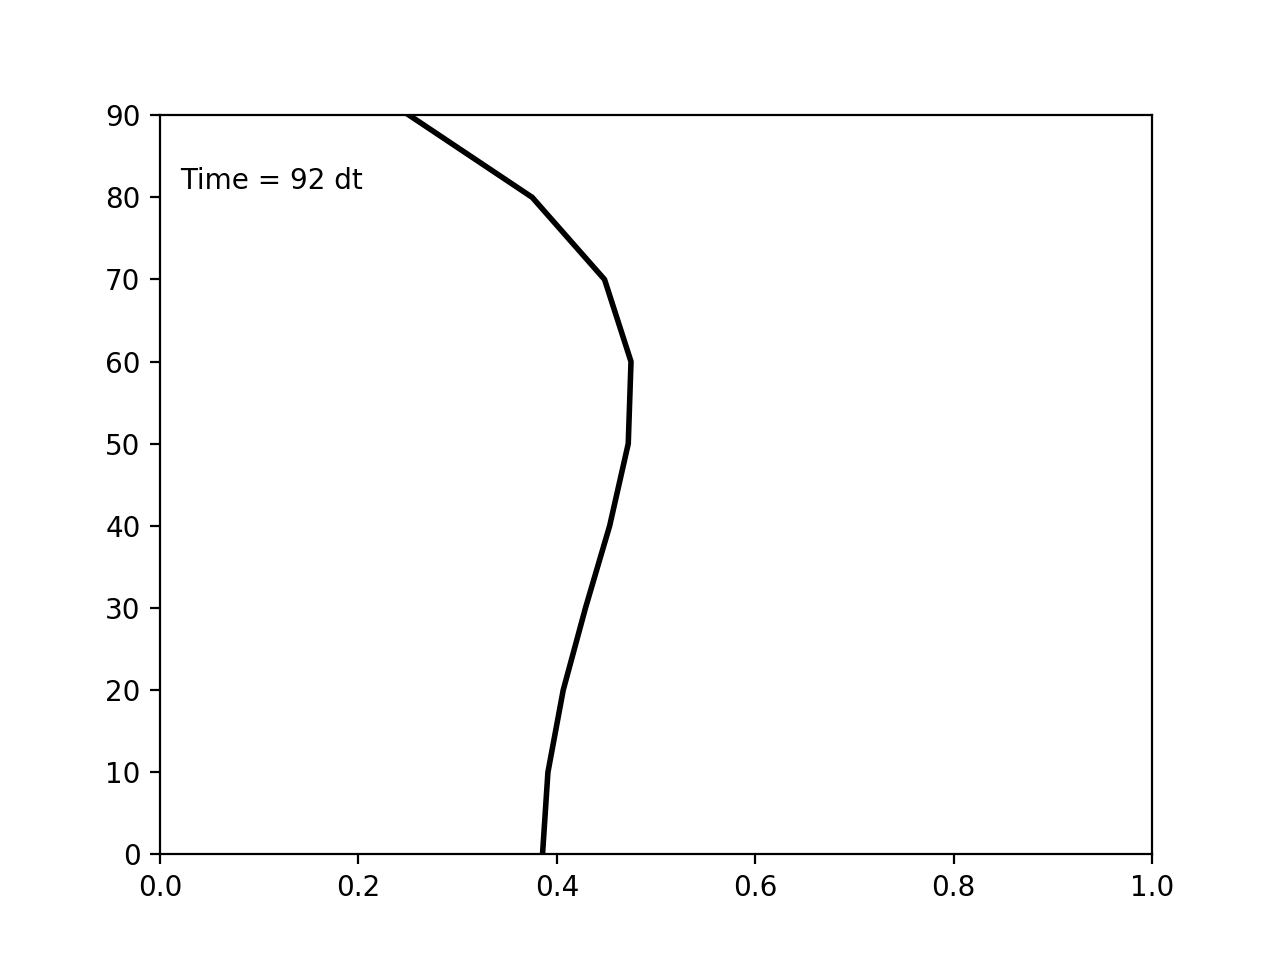

In [16]:
zs = np.arange(0,100,10)
ts = np.arange(0,100,1)
dt = 1
u = 0.
Tair = np.sin(np.pi*ts/max(ts))
qgeo = -0.#05

T = forwardModel(zs,ts,dt,u,Tair,qgeo)

fig = plt.figure()
ax = plt.axes(xlim=(np.min(T),np.max(T)), ylim=(min(zs),max(zs)))

# Define a term for the line that will be plotted and the time to print during animation
line, = ax.plot([], [],'k-',lw=2)
time_text = ax.text(0.02, 0.9, '', transform=ax.transAxes)

# Run the animation
# frames should be the length of the array so it plots every measurement (Here I have switched to only plotting one of the refreezing events)
# interval is in mSeconds and it gives a pause between plots so decrease to go faster
# blit=True says to only replot what has changed (this makes the function run faster)
ani = animation.FuncAnimation(fig, animate, fargs=(T,ts,zs),init_func=init,
                                     frames=len(ts), interval=10, blit=True)

In [6]:
### Analytical Solutions ###



# Surface Temperature Harmonic Function
def harmonicSurface(T0,Ta,rho,C,k,t,x,w):
    # diffusivity
    alpha = k/(rho*C)
    # equation 2.6-8 from Carslaw and Jaegar (1959)
    T = T0 + Ta * np.exp(-x*np.sqrt(w/(2.*alpha))) * np.cos((w*t)-x*np.sqrt(w/(2*alpha)))
    return T

def harmonicAdvection(T0,Ta,rho,C,k,t,x,w,vel):
    # diffusivity
    alpha = k/(rho*C)
    # set up with variables from LZ (1995) eq. 4.4
    phi = w/alpha
    psi = vel**2/(4*alpha**2)
    mu = np.sqrt((np.sqrt(phi**2+psi**2)+psi)/2.)
    lam = np.sqrt((np.sqrt(phi**2+psi**2)-psi)/2.)
    # Logan and Zlotnic (1995) eq. 4.6
    T = T0 + Ta * np.exp((vel/(2*alpha)-mu)*x) * np.cos(w*t-lam*x)
    return T